In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from itertools import product
from shapely.geometry import Polygon, Point

## Generate polygon geographies

First we need an engine that generates grids of different sides:

In [51]:
def gridder(nr, nc):
    '''
    Return a grid with `nr` by `nc` polygons
    ...
    
    Arguments
    ---------
    nr     : int
             Number of rows
    nc     : int
             Number of columns
    '''
    x_breaks = np.linspace(0, 1, nc+1)
    y_breaks = np.linspace(0, 1, nr+1)
    polys = []
    for x, y in product(range(nc), range(nr)):
        poly = [(x_breaks[x], y_breaks[y]), \
                (x_breaks[x], y_breaks[y+1]), \
                (x_breaks[x+1], y_breaks[y+1]), \
                (x_breaks[x+1], y_breaks[y])]
        polys.append(Polygon(poly))
    return gpd.GeoSeries(polys)

It's then easy to generate a grid of polygons as a `GeoSeries`:

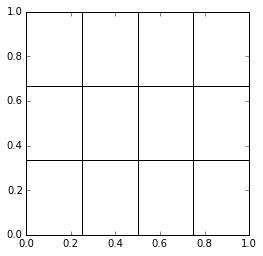

In [48]:
polys = gridder(3, 4)
polys.plot(alpha=0)
plt.show()

## Generate points within the geography

Then we can generate a random amount of points that fall within our polygons:

In [109]:
def gen_pts(n):
    xy = pd.DataFrame(np.random.random((n, 2)), columns=['X', 'Y'])
    pts = gpd.GeoSeries(xy.apply(Point, axis=1))
    return pts

In [71]:
np.random.seed(123)
pts = gen_pts(100)
pts.head()

0    POINT (0.6964691855978616 0.2861393349503795)
1    POINT (0.2268514535642031 0.5513147690828912)
2     POINT (0.7194689697855631 0.423106460124461)
3    POINT (0.9807641983846155 0.6848297385848633)
4    POINT (0.4809319014843609 0.3921175181941505)
dtype: object

Which, plotted over the polygon geography look like:

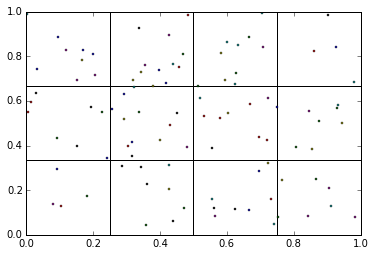

In [52]:
f, ax = plt.subplots(1)
polys.plot(alpha=0, axes=ax)
pts.plot(axes=ax)
plt.show()

## Aggregate points to polygon

Then we can aggregate the number of points into each polygon:

In [57]:
def map_pt2poly(pts, polys):
    mapa = []
    for i, pt in pts.iteritems():
        for j, poly in polys.iteritems():
            if poly.contains(pt):
                mapa.append((i, j))
                pass
    mapa = np.array(mapa)
    mapa = pd.Series(mapa[:, 1], index=mapa[:, 0])
    return mapa

In [64]:
pt2poly = map_pt2poly(pts, polys)
count = pt2poly.groupby(pt2poly).size()
db = gpd.GeoDataFrame({'geometry': polys, 'count': count})
db.head()

,count,geometry
0,4,"POLYGON ((0 0, 0 0.3333333333333333, 0.25 0.33..."
1,8,"POLYGON ((0 0.3333333333333333, 0 0.6666666666..."
2,9,"POLYGON ((0 0.6666666666666666, 0 1, 0.25 1, 0..."
3,8,"POLYGON ((0.25 0, 0.25 0.3333333333333333, 0.5..."
4,12,"POLYGON ((0.25 0.3333333333333333, 0.25 0.6666..."


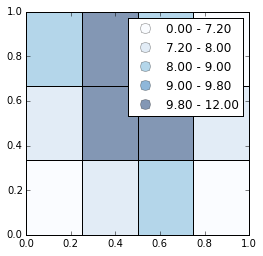

In [67]:
db.plot(column='count', scheme='quantiles', legend=True, colormap='Blues')

## Automated

We can now think of encapsulating all of this into a single method that takes `nr`, `nc` and the points we want to plot and generate a table of counts per polygon:

In [90]:
def count_table(nr, nc, pts):
    polys = gridder(nr, nc)
    walk = map_pt2poly(pts, polys)
    count = walk.groupby(walk).size().reindex(polys.index).fillna(0)
    tab = gpd.GeoDataFrame({'geometry': polys, 'count': count})
    return tab

In [87]:
counts_5x5 = count_table(5, 5, pts)
counts_5x5.head()

,count,geometry
0,3,"POLYGON ((0 0, 0 0.2, 0.2 0.2, 0.2 0, 0 0))"
1,2,"POLYGON ((0 0.2, 0 0.4, 0.2 0.4, 0.2 0.2, 0 0.2))"
2,4,"POLYGON ((0 0.4, 0 0.6000000000000001, 0.2 0.6..."
3,4,"POLYGON ((0 0.6000000000000001, 0 0.8, 0.2 0.8..."
4,4,"POLYGON ((0 0.8, 0 1, 0.2 1, 0.2 0.8, 0 0.8))"


## MAUP

Now let's explore what the choropleth looks like for the same set of points when we put them in different geographies:

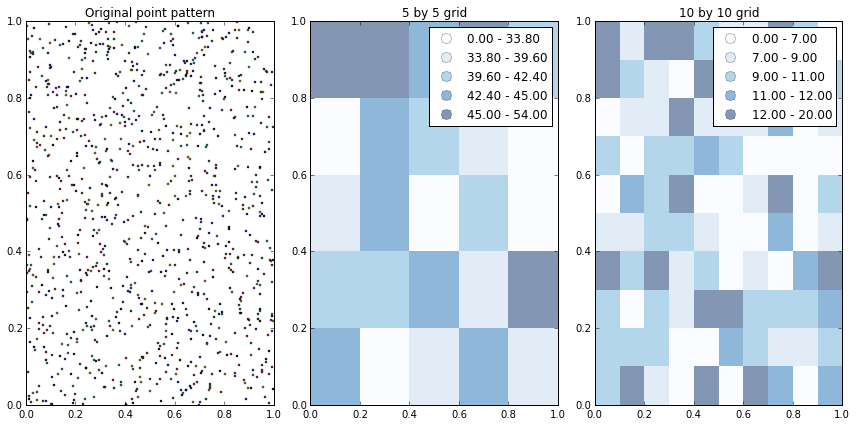

CPU times: user 4.18 s, sys: 17.8 ms, total: 4.2 s
Wall time: 4.21 s


In [115]:
%%time
np.random.seed(123)
pts = gen_pts(1000)
sizes = [5, 10]
f, axs = plt.subplots(1, len(sizes)+1, figsize=(6*len(sizes), 6))
pts.plot(axes=axs[0])
axs[0].set_title('Original point pattern')
for size, ax in zip(sizes, axs[1:]):
    tab = count_table(size, size, pts)
    tab.plot(column='count', scheme='quantiles', legend=True, \
             colormap='Blues', axes=ax, linewidth=0)
    ax.set_title("%i by %i grid"%(size, size))
plt.show()

Or, individually:

In [120]:
def plot_case(nr, nc, pts):
    tab = count_table(nr, nc, pts)
    f, axs = plt.subplots(1, 3, figsize=(18, 6))
    pts.plot(axes=axs[0])
    tab.plot(alpha=0, axes=axs[1])
    tab.plot(column='count', scheme='quantiles', \
             colormap='Blues', axes=axs[2], linewidth=0)
    plt.show()

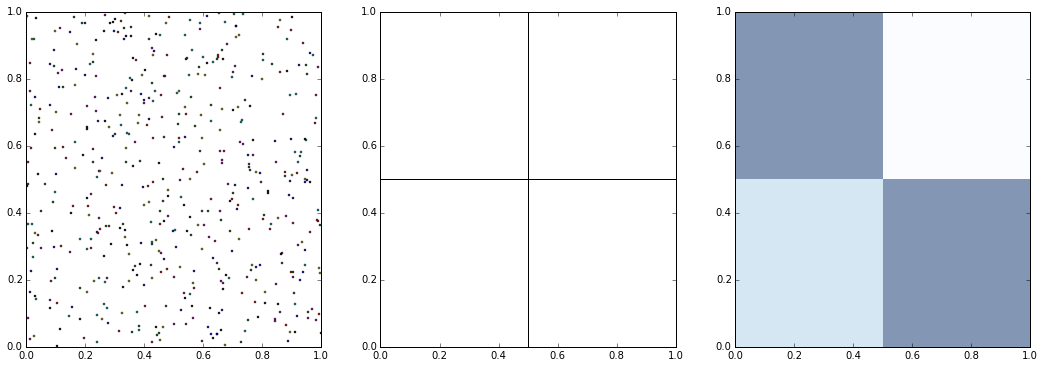

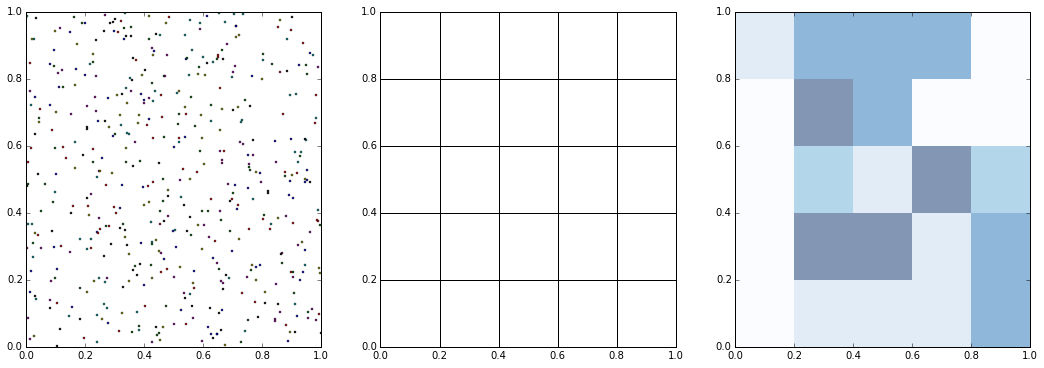

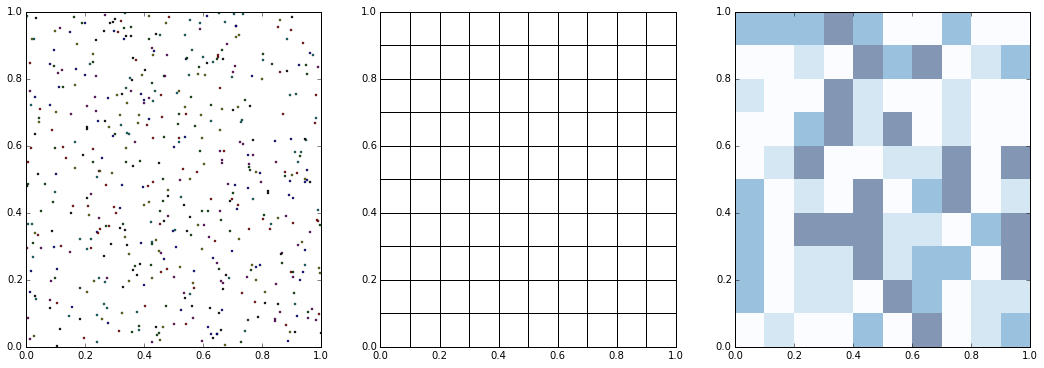

In [121]:
np.random.seed(123)
pts = gen_pts(500)
plot_case(2, 2, pts)
plot_case(5, 5, pts)
plot_case(10, 10, pts)

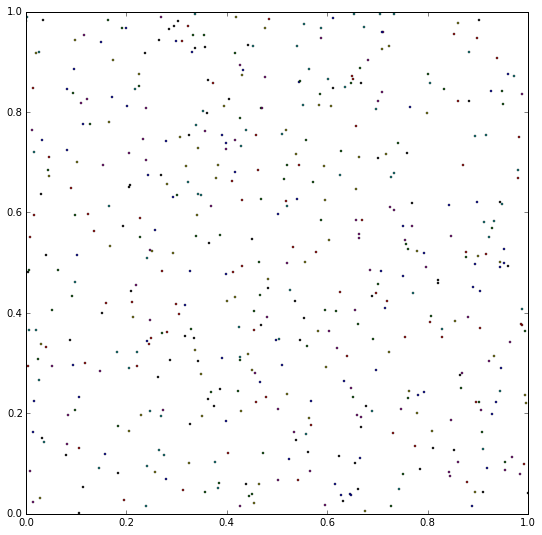

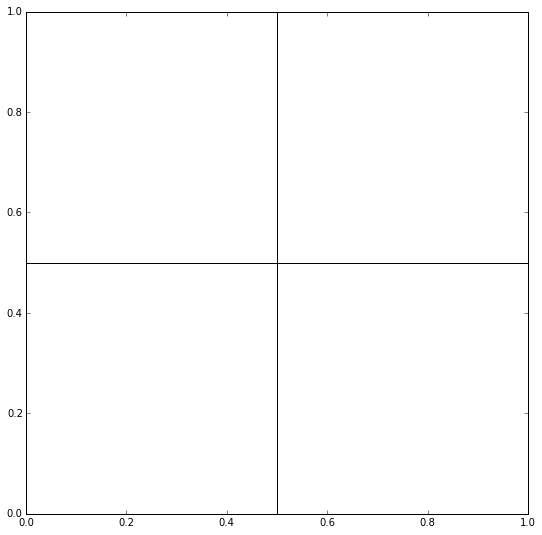

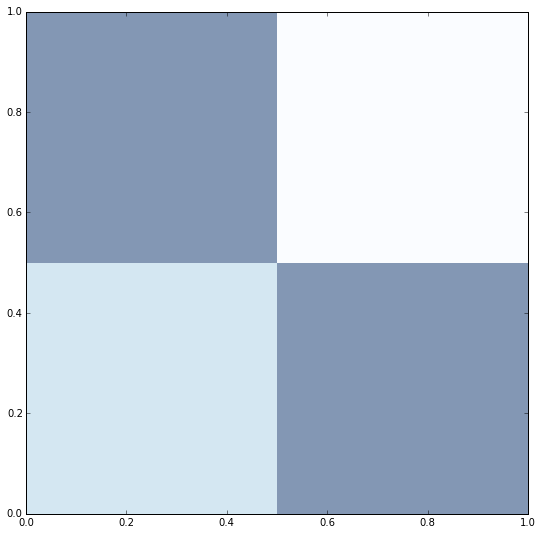

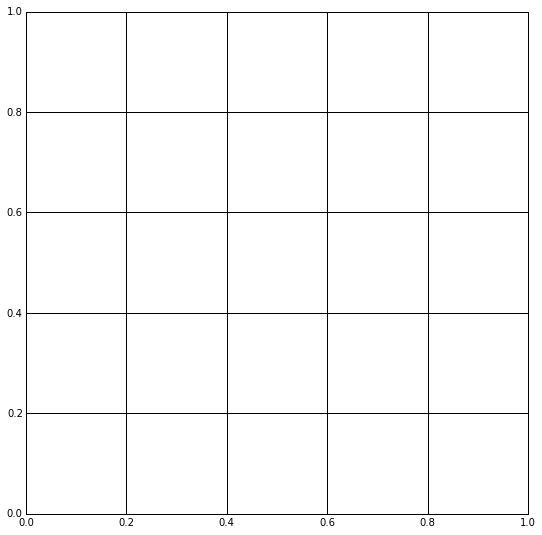

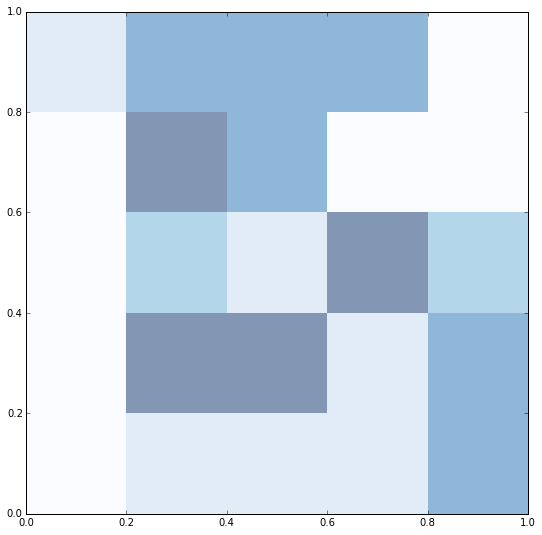

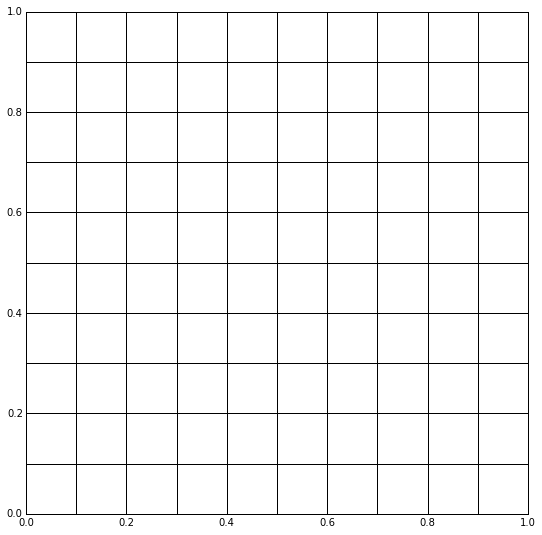

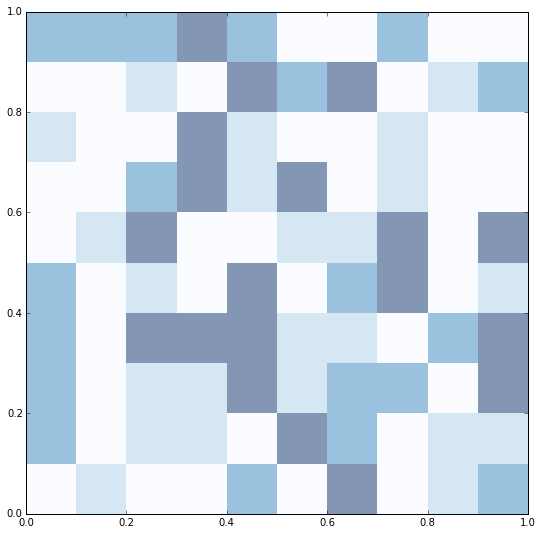

In [127]:
np.random.seed(123)
pts = gen_pts(500)
path = '../lectures/figs/'

f, ax = plt.subplots(1, figsize=(9, 9))
pts.plot(axes=ax)
plt.savefig(path+'l04_maup_pts.png')

nr, nc = 2, 2
tab = count_table(nr, nc, pts)
f, ax = plt.subplots(1, figsize=(9, 9))
tab.plot(alpha=0, axes=ax)
plt.savefig(path+'l04_maup_2x2_grid.png')

f, ax = plt.subplots(1, figsize=(9, 9))
tab.plot(column='count', scheme='quantiles', legend=False, \
         colormap='Blues', axes=ax, linewidth=0)
plt.savefig(path+'l04_maup_2x2_map.png')

nr, nc = 5, 5
tab = count_table(nr, nc, pts)
f, ax = plt.subplots(1, figsize=(9, 9))
tab.plot(alpha=0, axes=ax)
plt.savefig(path+'l04_maup_5x5_grid.png')

f, ax = plt.subplots(1, figsize=(9, 9))
tab.plot(column='count', scheme='quantiles', legend=False, \
         colormap='Blues', axes=ax, linewidth=0)
plt.savefig(path+'l04_maup_5x5_map.png')

nr, nc = 10, 10
tab = count_table(nr, nc, pts)
f, ax = plt.subplots(1, figsize=(9, 9))
tab.plot(alpha=0, axes=ax)
plt.savefig(path+'l04_maup_10x10_grid.png')

f, ax = plt.subplots(1, figsize=(9, 9))
tab.plot(column='count', scheme='quantiles', legend=False, \
         colormap='Blues', axes=ax, linewidth=0)
plt.savefig(path+'l04_maup_10x10_map.png')